##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 이미지 분류자 다시 훈련하기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

## 소개

이미지 분류 모델에는 수백만 개의 매개변수가 있습니다. 처음부터 훈련하려면 레이블이 지정된 많은 훈련 데이터와 많은 컴퓨팅 성능이 필요합니다. 전이 학습은 관련 작업에서 이미 훈련된 모델 조각을 가져와 새 모델에서 재사용함으로써 이러한 많은 자원 소모를 줄이는 기술입니다.

이 Colab은 이미지 특성 추출을 위해 TensorFlow Hub에서 사전 훈련된 TF2 SavedModel(훨씬 크고 더 일반적인 ImageNet 데이터세트에서 훈련됨)을 사용하여 5종의 꽃을 분류하기 위한 Keras 모델을 빌드하는 방법을 보여줍니다. 선택적으로, 특성 extractor를 새로 추가된 분류자와 함께 훈련("미세 조정")할 수 있습니다.

### 이것 말고 도구를 찾고 있습니까?

본 내용은 TensorFlow 코딩 튜토리얼입니다. TensorFlow 또는 TF Lite 모델을 빌드하는 도구를 원하는 경우 PIP 패키지 `tensorflow-hub[make_image_classifier]`를 통해 [설치](https://www.tensorflow.org/hub/installation)되거나 [이](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) TF Lite colab에 있는 [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) 명령줄 도구를 살펴보세요.


## 설정

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2022-12-14 21:02:18.667701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:02:18.667812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:02:18.667822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TF version: 2.11.0
Hub version: 0.12.0
GPU is available


## 사용할 TF2 SavedModel 모듈 선택하기

처음 시작하는 경우 [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)를 사용하세요. 동일한 URL을 코드에 사용하여 SavedModel을 식별하고 브라우저에서 설명서를 표시할 수 있습니다. 참고로 TF1 Hub 형식의 모델은 여기서 작동하지 않습니다.

[여기](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)에서 이미지 특성 벡터를 생성하는 더 많은 TF2 모델을 찾을 수 있습니다.

시도할 수 있는 여러 모델이 있습니다. 아래 셀에서 다른 모델을 선택하고 노트북을 사용하기만 하면 됩니다.

In [3]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## Flowers 데이터세트 설정하기

입력은 선택한 모듈에 맞게 적절한 크기로 조정됩니다. 데이터세트 확대(즉, 읽을 때마다 이미지의 임의 왜곡)로 특히 미세 조정할 때 훈련이 개선됩니다.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

  8396800/228813984 [>.............................] - ETA: 3s

 21553152/228813984 [=>............................] - ETA: 1s

 35782656/228813984 [===>..........................] - ETA: 1s

 44777472/228813984 [====>.........................] - ETA: 1s

 58556416/228813984 [======>.......................] - ETA: 0s

 73228288/228813984 [========>.....................] - ETA: 0s

 75505664/228813984 [========>.....................] - ETA: 0s

 88989696/228813984 [==========>...................] - ETA: 0s

104071168/228813984 [============>.................] - ETA: 0s

114966528/228813984 [==============>...............] - ETA: 0s

130187264/228813984 [================>.............] - ETA: 0s

143310848/228813984 [=================>............] - ETA: 0s

150732800/228813984 [==================>...........] - ETA: 0s

159006720/228813984 [===================>..........] - ETA: 0s

169459712/228813984 [=====================>........] - ETA: 0s

182214656/228813984 [======================>.......] - ETA: 0s

195297280/228813984 [========================>.....] - ETA: 0s

205996032/228813984 [==========================>...] - ETA: 0s

217735168/228813984 [===========================>..] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 모델 정의하기

Hub 모듈을 사용하여 `feature_extractor_layer` 위에 선형 분류자를 배치하기만 하면 됩니다.

속도를 높이기 위해 훈련할 수 없는 `feature_extractor_layer`로 시작하지만 정확성을 높이기 위해 미세 조정을 사용할 수도 있습니다.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 1280)              207615832 


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 207,622,237


Trainable params: 6,405


Non-trainable params: 207,615,832


_________________________________________________________________


## 모델 훈련하기

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:39:18 - loss: 3.0361 - accuracy: 0.0625

  2/183 [..............................] - ETA: 1:58 - loss: 2.5923 - accuracy: 0.1250   

  3/183 [..............................] - ETA: 1:58 - loss: 2.4131 - accuracy: 0.1875

  4/183 [..............................] - ETA: 1:57 - loss: 2.2162 - accuracy: 0.2344

  5/183 [..............................] - ETA: 1:56 - loss: 2.0055 - accuracy: 0.3375

  6/183 [..............................] - ETA: 1:56 - loss: 1.8617 - accuracy: 0.4167

  7/183 [>.............................] - ETA: 1:55 - loss: 1.8219 - accuracy: 0.4554

  8/183 [>.............................] - ETA: 1:54 - loss: 1.7609 - accuracy: 0.4844

  9/183 [>.............................] - ETA: 1:54 - loss: 1.7125 - accuracy: 0.5208

 10/183 [>.............................] - ETA: 1:53 - loss: 1.6483 - accuracy: 0.5437

 11/183 [>.............................] - ETA: 1:52 - loss: 1.5742 - accuracy: 0.5795

 12/183 [>.............................] - ETA: 1:52 - loss: 1.5184 - accuracy: 0.6094

 13/183 [=>............................] - ETA: 1:51 - loss: 1.4861 - accuracy: 0.6250

 14/183 [=>............................] - ETA: 1:50 - loss: 1.4618 - accuracy: 0.6384

 15/183 [=>............................] - ETA: 1:50 - loss: 1.4382 - accuracy: 0.6583

 16/183 [=>............................] - ETA: 1:49 - loss: 1.4084 - accuracy: 0.6797

 17/183 [=>............................] - ETA: 1:48 - loss: 1.3765 - accuracy: 0.6985

 18/183 [=>............................] - ETA: 1:48 - loss: 1.3457 - accuracy: 0.7118

 19/183 [==>...........................] - ETA: 1:47 - loss: 1.3299 - accuracy: 0.7270

 20/183 [==>...........................] - ETA: 1:46 - loss: 1.3113 - accuracy: 0.7375

 21/183 [==>...........................] - ETA: 1:46 - loss: 1.2914 - accuracy: 0.7500

 22/183 [==>...........................] - ETA: 1:45 - loss: 1.2817 - accuracy: 0.7585

 23/183 [==>...........................] - ETA: 1:44 - loss: 1.2897 - accuracy: 0.7636

 24/183 [==>...........................] - ETA: 1:44 - loss: 1.2754 - accuracy: 0.7708

 25/183 [===>..........................] - ETA: 1:43 - loss: 1.2747 - accuracy: 0.7725

 26/183 [===>..........................] - ETA: 1:42 - loss: 1.2612 - accuracy: 0.7788

 27/183 [===>..........................] - ETA: 1:42 - loss: 1.2638 - accuracy: 0.7824

 28/183 [===>..........................] - ETA: 1:41 - loss: 1.2494 - accuracy: 0.7902

 29/183 [===>..........................] - ETA: 1:40 - loss: 1.2414 - accuracy: 0.7953

 30/183 [===>..........................] - ETA: 1:40 - loss: 1.2299 - accuracy: 0.8000

 31/183 [====>.........................] - ETA: 1:39 - loss: 1.2207 - accuracy: 0.8044

 32/183 [====>.........................] - ETA: 1:38 - loss: 1.2116 - accuracy: 0.8105

 33/183 [====>.........................] - ETA: 1:38 - loss: 1.2094 - accuracy: 0.8144

 34/183 [====>.........................] - ETA: 1:37 - loss: 1.2100 - accuracy: 0.8162

 35/183 [====>.........................] - ETA: 1:36 - loss: 1.2060 - accuracy: 0.8161

 36/183 [====>.........................] - ETA: 1:36 - loss: 1.1935 - accuracy: 0.8212

 37/183 [=====>........................] - ETA: 1:35 - loss: 1.1897 - accuracy: 0.8209

 38/183 [=====>........................] - ETA: 1:35 - loss: 1.1823 - accuracy: 0.8240

 39/183 [=====>........................] - ETA: 1:34 - loss: 1.1722 - accuracy: 0.8269

 40/183 [=====>........................] - ETA: 1:33 - loss: 1.1665 - accuracy: 0.8297

 41/183 [=====>........................] - ETA: 1:33 - loss: 1.1647 - accuracy: 0.8308

 42/183 [=====>........................] - ETA: 1:32 - loss: 1.1611 - accuracy: 0.8333

 43/183 [======>.......................] - ETA: 1:31 - loss: 1.1614 - accuracy: 0.8358

 44/183 [======>.......................] - ETA: 1:31 - loss: 1.1517 - accuracy: 0.8395

 45/183 [======>.......................] - ETA: 1:30 - loss: 1.1446 - accuracy: 0.8417

 46/183 [======>.......................] - ETA: 1:29 - loss: 1.1437 - accuracy: 0.8424

 47/183 [======>.......................] - ETA: 1:29 - loss: 1.1454 - accuracy: 0.8431

 48/183 [======>.......................] - ETA: 1:28 - loss: 1.1373 - accuracy: 0.8451

 49/183 [=======>......................] - ETA: 1:27 - loss: 1.1323 - accuracy: 0.8469

 50/183 [=======>......................] - ETA: 1:27 - loss: 1.1264 - accuracy: 0.8487

 51/183 [=======>......................] - ETA: 1:26 - loss: 1.1309 - accuracy: 0.8468

 52/183 [=======>......................] - ETA: 1:25 - loss: 1.1231 - accuracy: 0.8486

 53/183 [=======>......................] - ETA: 1:25 - loss: 1.1162 - accuracy: 0.8502

 54/183 [=======>......................] - ETA: 1:24 - loss: 1.1107 - accuracy: 0.8519

 55/183 [========>.....................] - ETA: 1:23 - loss: 1.1011 - accuracy: 0.8534

 56/183 [========>.....................] - ETA: 1:23 - loss: 1.0963 - accuracy: 0.8549

 57/183 [========>.....................] - ETA: 1:22 - loss: 1.0877 - accuracy: 0.8564

 58/183 [========>.....................] - ETA: 1:21 - loss: 1.0808 - accuracy: 0.8578

 59/183 [========>.....................] - ETA: 1:21 - loss: 1.0817 - accuracy: 0.8570

 60/183 [========>.....................] - ETA: 1:20 - loss: 1.0732 - accuracy: 0.8594

 61/183 [=========>....................] - ETA: 1:19 - loss: 1.0685 - accuracy: 0.8607

 62/183 [=========>....................] - ETA: 1:19 - loss: 1.0660 - accuracy: 0.8609

 63/183 [=========>....................] - ETA: 1:18 - loss: 1.0698 - accuracy: 0.8601

 64/183 [=========>....................] - ETA: 1:17 - loss: 1.0678 - accuracy: 0.8613

 65/183 [=========>....................] - ETA: 1:17 - loss: 1.0605 - accuracy: 0.8635

 66/183 [=========>....................] - ETA: 1:16 - loss: 1.0611 - accuracy: 0.8627

 67/183 [=========>....................] - ETA: 1:15 - loss: 1.0555 - accuracy: 0.8638

 68/183 [==========>...................] - ETA: 1:15 - loss: 1.0529 - accuracy: 0.8640

 69/183 [==========>...................] - ETA: 1:14 - loss: 1.0469 - accuracy: 0.8659

 70/183 [==========>...................] - ETA: 1:14 - loss: 1.0405 - accuracy: 0.8670

 71/183 [==========>...................] - ETA: 1:13 - loss: 1.0371 - accuracy: 0.8671

 72/183 [==========>...................] - ETA: 1:12 - loss: 1.0313 - accuracy: 0.8689

 73/183 [==========>...................] - ETA: 1:12 - loss: 1.0314 - accuracy: 0.8690

 74/183 [===========>..................] - ETA: 1:11 - loss: 1.0274 - accuracy: 0.8682

 75/183 [===========>..................] - ETA: 1:10 - loss: 1.0300 - accuracy: 0.8667

 76/183 [===========>..................] - ETA: 1:10 - loss: 1.0285 - accuracy: 0.8668

 77/183 [===========>..................] - ETA: 1:09 - loss: 1.0316 - accuracy: 0.8653

 78/183 [===========>..................] - ETA: 1:08 - loss: 1.0327 - accuracy: 0.8662

 79/183 [===========>..................] - ETA: 1:08 - loss: 1.0276 - accuracy: 0.8671

 80/183 [============>.................] - ETA: 1:07 - loss: 1.0226 - accuracy: 0.8680

 81/183 [============>.................] - ETA: 1:06 - loss: 1.0192 - accuracy: 0.8688

 82/183 [============>.................] - ETA: 1:06 - loss: 1.0140 - accuracy: 0.8704

 83/183 [============>.................] - ETA: 1:05 - loss: 1.0122 - accuracy: 0.8705

 84/183 [============>.................] - ETA: 1:04 - loss: 1.0094 - accuracy: 0.8713

 85/183 [============>.................] - ETA: 1:04 - loss: 1.0117 - accuracy: 0.8713

 86/183 [=============>................] - ETA: 1:03 - loss: 1.0091 - accuracy: 0.8699

 87/183 [=============>................] - ETA: 1:02 - loss: 1.0053 - accuracy: 0.8700

 88/183 [=============>................] - ETA: 1:02 - loss: 1.0008 - accuracy: 0.8714

 89/183 [=============>................] - ETA: 1:01 - loss: 0.9964 - accuracy: 0.8722

 90/183 [=============>................] - ETA: 1:00 - loss: 0.9989 - accuracy: 0.8708

 91/183 [=============>................] - ETA: 1:00 - loss: 0.9984 - accuracy: 0.8709

 92/183 [==============>...............] - ETA: 59s - loss: 0.9975 - accuracy: 0.8709 

 93/183 [==============>...............] - ETA: 58s - loss: 0.9953 - accuracy: 0.8703

 94/183 [==============>...............] - ETA: 58s - loss: 0.9925 - accuracy: 0.8710

 95/183 [==============>...............] - ETA: 57s - loss: 0.9993 - accuracy: 0.8704

 96/183 [==============>...............] - ETA: 56s - loss: 0.9956 - accuracy: 0.8711

 97/183 [==============>...............] - ETA: 56s - loss: 0.9922 - accuracy: 0.8718

 98/183 [===============>..............] - ETA: 55s - loss: 0.9906 - accuracy: 0.8718

 99/183 [===============>..............] - ETA: 55s - loss: 0.9882 - accuracy: 0.8718

100/183 [===============>..............] - ETA: 54s - loss: 0.9850 - accuracy: 0.8725

101/183 [===============>..............] - ETA: 53s - loss: 0.9822 - accuracy: 0.8731

102/183 [===============>..............] - ETA: 53s - loss: 0.9787 - accuracy: 0.8738

103/183 [===============>..............] - ETA: 52s - loss: 0.9797 - accuracy: 0.8744

104/183 [================>.............] - ETA: 51s - loss: 0.9779 - accuracy: 0.8744

105/183 [================>.............] - ETA: 51s - loss: 0.9758 - accuracy: 0.8750

106/183 [================>.............] - ETA: 50s - loss: 0.9721 - accuracy: 0.8762

107/183 [================>.............] - ETA: 49s - loss: 0.9687 - accuracy: 0.8773

108/183 [================>.............] - ETA: 49s - loss: 0.9673 - accuracy: 0.8773

109/183 [================>.............] - ETA: 48s - loss: 0.9641 - accuracy: 0.8784

110/183 [=================>............] - ETA: 47s - loss: 0.9623 - accuracy: 0.8790

111/183 [=================>............] - ETA: 47s - loss: 0.9594 - accuracy: 0.8801

112/183 [=================>............] - ETA: 46s - loss: 0.9575 - accuracy: 0.8800

113/183 [=================>............] - ETA: 45s - loss: 0.9547 - accuracy: 0.8800

114/183 [=================>............] - ETA: 45s - loss: 0.9516 - accuracy: 0.8810

115/183 [=================>............] - ETA: 44s - loss: 0.9525 - accuracy: 0.8799

116/183 [==================>...........] - ETA: 43s - loss: 0.9496 - accuracy: 0.8809

117/183 [==================>...........] - ETA: 43s - loss: 0.9477 - accuracy: 0.8814

118/183 [==================>...........] - ETA: 42s - loss: 0.9447 - accuracy: 0.8824

119/183 [==================>...........] - ETA: 41s - loss: 0.9417 - accuracy: 0.8834

120/183 [==================>...........] - ETA: 41s - loss: 0.9401 - accuracy: 0.8839

121/183 [==================>...........] - ETA: 40s - loss: 0.9383 - accuracy: 0.8843

122/183 [===================>..........] - ETA: 39s - loss: 0.9376 - accuracy: 0.8847

123/183 [===================>..........] - ETA: 39s - loss: 0.9370 - accuracy: 0.8852

124/183 [===================>..........] - ETA: 38s - loss: 0.9368 - accuracy: 0.8851

125/183 [===================>..........] - ETA: 37s - loss: 0.9358 - accuracy: 0.8850

126/183 [===================>..........] - ETA: 37s - loss: 0.9342 - accuracy: 0.8849

127/183 [===================>..........] - ETA: 36s - loss: 0.9323 - accuracy: 0.8853

128/183 [===================>..........] - ETA: 36s - loss: 0.9294 - accuracy: 0.8857

129/183 [====================>.........] - ETA: 35s - loss: 0.9267 - accuracy: 0.8866

130/183 [====================>.........] - ETA: 34s - loss: 0.9249 - accuracy: 0.8865

131/183 [====================>.........] - ETA: 34s - loss: 0.9237 - accuracy: 0.8865

132/183 [====================>.........] - ETA: 33s - loss: 0.9212 - accuracy: 0.8868

133/183 [====================>.........] - ETA: 32s - loss: 0.9193 - accuracy: 0.8872

134/183 [====================>.........] - ETA: 32s - loss: 0.9171 - accuracy: 0.8876

135/183 [=====================>........] - ETA: 31s - loss: 0.9156 - accuracy: 0.8880

136/183 [=====================>........] - ETA: 30s - loss: 0.9157 - accuracy: 0.8879

137/183 [=====================>........] - ETA: 30s - loss: 0.9144 - accuracy: 0.8882

138/183 [=====================>........] - ETA: 29s - loss: 0.9134 - accuracy: 0.8886

139/183 [=====================>........] - ETA: 28s - loss: 0.9114 - accuracy: 0.8889

140/183 [=====================>........] - ETA: 28s - loss: 0.9091 - accuracy: 0.8897

141/183 [======================>.......] - ETA: 27s - loss: 0.9121 - accuracy: 0.8896

142/183 [======================>.......] - ETA: 26s - loss: 0.9101 - accuracy: 0.8904

143/183 [======================>.......] - ETA: 26s - loss: 0.9102 - accuracy: 0.8907

144/183 [======================>.......] - ETA: 25s - loss: 0.9087 - accuracy: 0.8911

145/183 [======================>.......] - ETA: 24s - loss: 0.9083 - accuracy: 0.8914

146/183 [======================>.......] - ETA: 24s - loss: 0.9069 - accuracy: 0.8917

147/183 [=======================>......] - ETA: 23s - loss: 0.9056 - accuracy: 0.8924

148/183 [=======================>......] - ETA: 22s - loss: 0.9043 - accuracy: 0.8923

149/183 [=======================>......] - ETA: 22s - loss: 0.9030 - accuracy: 0.8922

150/183 [=======================>......] - ETA: 21s - loss: 0.9028 - accuracy: 0.8925

151/183 [=======================>......] - ETA: 20s - loss: 0.9009 - accuracy: 0.8932

152/183 [=======================>......] - ETA: 20s - loss: 0.8996 - accuracy: 0.8935

153/183 [========================>.....] - ETA: 19s - loss: 0.8992 - accuracy: 0.8934

154/183 [========================>.....] - ETA: 19s - loss: 0.8976 - accuracy: 0.8937

155/183 [========================>.....] - ETA: 18s - loss: 0.8955 - accuracy: 0.8944

156/183 [========================>.....] - ETA: 17s - loss: 0.8949 - accuracy: 0.8946

157/183 [========================>.....] - ETA: 17s - loss: 0.8951 - accuracy: 0.8945

158/183 [========================>.....] - ETA: 16s - loss: 0.8937 - accuracy: 0.8948

159/183 [=========================>....] - ETA: 15s - loss: 0.8919 - accuracy: 0.8950

160/183 [=========================>....] - ETA: 15s - loss: 0.8923 - accuracy: 0.8949

161/183 [=========================>....] - ETA: 14s - loss: 0.8906 - accuracy: 0.8956

162/183 [=========================>....] - ETA: 13s - loss: 0.8894 - accuracy: 0.8954

163/183 [=========================>....] - ETA: 13s - loss: 0.8898 - accuracy: 0.8953

164/183 [=========================>....] - ETA: 12s - loss: 0.8886 - accuracy: 0.8956

165/183 [==========================>...] - ETA: 11s - loss: 0.8879 - accuracy: 0.8958

166/183 [==========================>...] - ETA: 11s - loss: 0.8859 - accuracy: 0.8965

167/183 [==========================>...] - ETA: 10s - loss: 0.8850 - accuracy: 0.8963

168/183 [==========================>...] - ETA: 9s - loss: 0.8839 - accuracy: 0.8962 

169/183 [==========================>...] - ETA: 9s - loss: 0.8852 - accuracy: 0.8953

170/183 [==========================>...] - ETA: 8s - loss: 0.8847 - accuracy: 0.8952

171/183 [===========================>..] - ETA: 7s - loss: 0.8837 - accuracy: 0.8955

172/183 [===========================>..] - ETA: 7s - loss: 0.8824 - accuracy: 0.8953

173/183 [===========================>..] - ETA: 6s - loss: 0.8818 - accuracy: 0.8956

174/183 [===========================>..] - ETA: 5s - loss: 0.8806 - accuracy: 0.8958

175/183 [===========================>..] - ETA: 5s - loss: 0.8806 - accuracy: 0.8957

176/183 [===========================>..] - ETA: 4s - loss: 0.8816 - accuracy: 0.8952

177/183 [============================>.] - ETA: 3s - loss: 0.8818 - accuracy: 0.8951

178/183 [============================>.] - ETA: 3s - loss: 0.8803 - accuracy: 0.8954

179/183 [============================>.] - ETA: 2s - loss: 0.8791 - accuracy: 0.8956

180/183 [============================>.] - ETA: 1s - loss: 0.8791 - accuracy: 0.8951

181/183 [============================>.] - ETA: 1s - loss: 0.8787 - accuracy: 0.8947

182/183 [============================>.] - ETA: 0s - loss: 0.8787 - accuracy: 0.8946

183/183 [==============================] - ETA: 0s - loss: 0.8805 - accuracy: 0.8945

183/183 [==============================] - 186s 843ms/step - loss: 0.8805 - accuracy: 0.8945 - val_loss: 0.7559 - val_accuracy: 0.9542


Epoch 2/5


  1/183 [..............................] - ETA: 2:42 - loss: 0.9225 - accuracy: 0.8750

  2/183 [..............................] - ETA: 1:58 - loss: 0.7706 - accuracy: 0.9167

  3/183 [..............................] - ETA: 1:57 - loss: 0.7002 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:57 - loss: 0.6921 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:56 - loss: 0.6958 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:56 - loss: 0.6995 - accuracy: 0.9432

  7/183 [>.............................] - ETA: 1:55 - loss: 0.6899 - accuracy: 0.9519

  8/183 [>.............................] - ETA: 1:54 - loss: 0.7121 - accuracy: 0.9417

  9/183 [>.............................] - ETA: 1:53 - loss: 0.7068 - accuracy: 0.9485

 10/183 [>.............................] - ETA: 1:53 - loss: 0.6997 - accuracy: 0.9539

 11/183 [>.............................] - ETA: 1:52 - loss: 0.7111 - accuracy: 0.9405

 12/183 [>.............................] - ETA: 1:51 - loss: 0.7147 - accuracy: 0.9402

 13/183 [=>............................] - ETA: 1:51 - loss: 0.7093 - accuracy: 0.9400

 14/183 [=>............................] - ETA: 1:50 - loss: 0.6984 - accuracy: 0.9444

 15/183 [=>............................] - ETA: 1:50 - loss: 0.6981 - accuracy: 0.9397

 16/183 [=>............................] - ETA: 1:49 - loss: 0.6970 - accuracy: 0.9355

 17/183 [=>............................] - ETA: 1:48 - loss: 0.6942 - accuracy: 0.9356

 18/183 [=>............................] - ETA: 1:48 - loss: 0.6991 - accuracy: 0.9321

 19/183 [==>...........................] - ETA: 1:47 - loss: 0.6931 - accuracy: 0.9358

 20/183 [==>...........................] - ETA: 1:46 - loss: 0.6943 - accuracy: 0.9327

 21/183 [==>...........................] - ETA: 1:46 - loss: 0.6968 - accuracy: 0.9329

 22/183 [==>...........................] - ETA: 1:45 - loss: 0.7048 - accuracy: 0.9331

 23/183 [==>...........................] - ETA: 1:44 - loss: 0.7032 - accuracy: 0.9333

 24/183 [==>...........................] - ETA: 1:44 - loss: 0.7139 - accuracy: 0.9282

 25/183 [===>..........................] - ETA: 1:43 - loss: 0.7104 - accuracy: 0.9286

 26/183 [===>..........................] - ETA: 1:42 - loss: 0.7072 - accuracy: 0.9289

 27/183 [===>..........................] - ETA: 1:42 - loss: 0.7114 - accuracy: 0.9245

 28/183 [===>..........................] - ETA: 1:41 - loss: 0.7116 - accuracy: 0.9250

 29/183 [===>..........................] - ETA: 1:40 - loss: 0.7092 - accuracy: 0.9254

 30/183 [===>..........................] - ETA: 1:40 - loss: 0.7089 - accuracy: 0.9237

 31/183 [====>.........................] - ETA: 1:39 - loss: 0.7124 - accuracy: 0.9221

 32/183 [====>.........................] - ETA: 1:38 - loss: 0.7136 - accuracy: 0.9226

 33/183 [====>.........................] - ETA: 1:38 - loss: 0.7117 - accuracy: 0.9250

 34/183 [====>.........................] - ETA: 1:37 - loss: 0.7085 - accuracy: 0.9272

 35/183 [====>.........................] - ETA: 1:36 - loss: 0.7088 - accuracy: 0.9275

 36/183 [====>.........................] - ETA: 1:36 - loss: 0.7080 - accuracy: 0.9278

 37/183 [=====>........................] - ETA: 1:35 - loss: 0.7059 - accuracy: 0.9281

 38/183 [=====>........................] - ETA: 1:34 - loss: 0.7059 - accuracy: 0.9267

 39/183 [=====>........................] - ETA: 1:34 - loss: 0.7061 - accuracy: 0.9269

 40/183 [=====>........................] - ETA: 1:33 - loss: 0.7048 - accuracy: 0.9288

 41/183 [=====>........................] - ETA: 1:33 - loss: 0.7030 - accuracy: 0.9306

 42/183 [=====>........................] - ETA: 1:32 - loss: 0.7075 - accuracy: 0.9292

 43/183 [======>.......................] - ETA: 1:31 - loss: 0.7062 - accuracy: 0.9294

 44/183 [======>.......................] - ETA: 1:31 - loss: 0.7032 - accuracy: 0.9310

 45/183 [======>.......................] - ETA: 1:30 - loss: 0.7008 - accuracy: 0.9326

 46/183 [======>.......................] - ETA: 1:29 - loss: 0.6989 - accuracy: 0.9341

 47/183 [======>.......................] - ETA: 1:29 - loss: 0.6982 - accuracy: 0.9341

 48/183 [======>.......................] - ETA: 1:28 - loss: 0.7056 - accuracy: 0.9342

 49/183 [=======>......................] - ETA: 1:27 - loss: 0.7043 - accuracy: 0.9343

 50/183 [=======>......................] - ETA: 1:27 - loss: 0.7054 - accuracy: 0.9331

 51/183 [=======>......................] - ETA: 1:26 - loss: 0.7058 - accuracy: 0.9319

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.7080 - accuracy: 0.9308

 53/183 [=======>......................] - ETA: 1:25 - loss: 0.7044 - accuracy: 0.9321

 54/183 [=======>......................] - ETA: 1:24 - loss: 0.7016 - accuracy: 0.9334

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.6994 - accuracy: 0.9335

 56/183 [========>.....................] - ETA: 1:23 - loss: 0.6975 - accuracy: 0.9336

 57/183 [========>.....................] - ETA: 1:22 - loss: 0.6944 - accuracy: 0.9347

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.6950 - accuracy: 0.9348

 59/183 [========>.....................] - ETA: 1:21 - loss: 0.6936 - accuracy: 0.9348

 60/183 [========>.....................] - ETA: 1:20 - loss: 0.6914 - accuracy: 0.9359

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.6884 - accuracy: 0.9370

 62/183 [=========>....................] - ETA: 1:19 - loss: 0.6863 - accuracy: 0.9380

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.6854 - accuracy: 0.9380

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.6918 - accuracy: 0.9360

 65/183 [=========>....................] - ETA: 1:17 - loss: 0.6896 - accuracy: 0.9370

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.6884 - accuracy: 0.9370

 67/183 [=========>....................] - ETA: 1:16 - loss: 0.6860 - accuracy: 0.9380

 68/183 [==========>...................] - ETA: 1:15 - loss: 0.6842 - accuracy: 0.9389

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.6825 - accuracy: 0.9389

 70/183 [==========>...................] - ETA: 1:14 - loss: 0.6809 - accuracy: 0.9397

 71/183 [==========>...................] - ETA: 1:13 - loss: 0.6794 - accuracy: 0.9406

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.6779 - accuracy: 0.9414

 73/183 [==========>...................] - ETA: 1:12 - loss: 0.6792 - accuracy: 0.9414

 74/183 [===========>..................] - ETA: 1:11 - loss: 0.6776 - accuracy: 0.9422

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.6774 - accuracy: 0.9413

 76/183 [===========>..................] - ETA: 1:10 - loss: 0.6778 - accuracy: 0.9412

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.6778 - accuracy: 0.9412

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.6758 - accuracy: 0.9419

 79/183 [===========>..................] - ETA: 1:08 - loss: 0.6760 - accuracy: 0.9419

 80/183 [============>.................] - ETA: 1:07 - loss: 0.6757 - accuracy: 0.9418

 81/183 [============>.................] - ETA: 1:06 - loss: 0.6764 - accuracy: 0.9410

 82/183 [============>.................] - ETA: 1:06 - loss: 0.6758 - accuracy: 0.9410

 83/183 [============>.................] - ETA: 1:05 - loss: 0.6754 - accuracy: 0.9409

 84/183 [============>.................] - ETA: 1:04 - loss: 0.6761 - accuracy: 0.9401

 85/183 [============>.................] - ETA: 1:04 - loss: 0.6793 - accuracy: 0.9386

 86/183 [=============>................] - ETA: 1:03 - loss: 0.6778 - accuracy: 0.9393

 87/183 [=============>................] - ETA: 1:02 - loss: 0.6790 - accuracy: 0.9379

 88/183 [=============>................] - ETA: 1:02 - loss: 0.6770 - accuracy: 0.9386

 89/183 [=============>................] - ETA: 1:01 - loss: 0.6762 - accuracy: 0.9386

 90/183 [=============>................] - ETA: 1:00 - loss: 0.6750 - accuracy: 0.9392

 91/183 [=============>................] - ETA: 1:00 - loss: 0.6755 - accuracy: 0.9392

 92/183 [==============>...............] - ETA: 59s - loss: 0.6749 - accuracy: 0.9392 

 93/183 [==============>...............] - ETA: 58s - loss: 0.6742 - accuracy: 0.9392

 94/183 [==============>...............] - ETA: 58s - loss: 0.6768 - accuracy: 0.9385

 95/183 [==============>...............] - ETA: 57s - loss: 0.6755 - accuracy: 0.9392

 96/183 [==============>...............] - ETA: 56s - loss: 0.6741 - accuracy: 0.9398

 97/183 [==============>...............] - ETA: 56s - loss: 0.6736 - accuracy: 0.9398

 98/183 [===============>..............] - ETA: 55s - loss: 0.6753 - accuracy: 0.9391

 99/183 [===============>..............] - ETA: 55s - loss: 0.6741 - accuracy: 0.9397

100/183 [===============>..............] - ETA: 54s - loss: 0.6728 - accuracy: 0.9403

101/183 [===============>..............] - ETA: 53s - loss: 0.6717 - accuracy: 0.9409

102/183 [===============>..............] - ETA: 53s - loss: 0.6703 - accuracy: 0.9415

103/183 [===============>..............] - ETA: 52s - loss: 0.6699 - accuracy: 0.9409

104/183 [================>.............] - ETA: 51s - loss: 0.6694 - accuracy: 0.9408

105/183 [================>.............] - ETA: 51s - loss: 0.6690 - accuracy: 0.9408

106/183 [================>.............] - ETA: 50s - loss: 0.6687 - accuracy: 0.9414

107/183 [================>.............] - ETA: 49s - loss: 0.6679 - accuracy: 0.9419

108/183 [================>.............] - ETA: 49s - loss: 0.6703 - accuracy: 0.9407

109/183 [================>.............] - ETA: 48s - loss: 0.6689 - accuracy: 0.9412

110/183 [=================>............] - ETA: 47s - loss: 0.6676 - accuracy: 0.9418

111/183 [=================>............] - ETA: 47s - loss: 0.6667 - accuracy: 0.9423

112/183 [=================>............] - ETA: 46s - loss: 0.6664 - accuracy: 0.9423

113/183 [=================>............] - ETA: 45s - loss: 0.6669 - accuracy: 0.9422

114/183 [=================>............] - ETA: 45s - loss: 0.6655 - accuracy: 0.9427

115/183 [=================>............] - ETA: 44s - loss: 0.6644 - accuracy: 0.9432

116/183 [==================>...........] - ETA: 43s - loss: 0.6645 - accuracy: 0.9432

117/183 [==================>...........] - ETA: 43s - loss: 0.6636 - accuracy: 0.9437

118/183 [==================>...........] - ETA: 42s - loss: 0.6631 - accuracy: 0.9436

119/183 [==================>...........] - ETA: 41s - loss: 0.6652 - accuracy: 0.9420

120/183 [==================>...........] - ETA: 41s - loss: 0.6652 - accuracy: 0.9419

121/183 [==================>...........] - ETA: 40s - loss: 0.6651 - accuracy: 0.9414

122/183 [===================>..........] - ETA: 39s - loss: 0.6641 - accuracy: 0.9419

123/183 [===================>..........] - ETA: 39s - loss: 0.6651 - accuracy: 0.9418

124/183 [===================>..........] - ETA: 38s - loss: 0.6666 - accuracy: 0.9413

125/183 [===================>..........] - ETA: 37s - loss: 0.6658 - accuracy: 0.9418

126/183 [===================>..........] - ETA: 37s - loss: 0.6654 - accuracy: 0.9422

127/183 [===================>..........] - ETA: 36s - loss: 0.6666 - accuracy: 0.9412

128/183 [===================>..........] - ETA: 36s - loss: 0.6656 - accuracy: 0.9417

129/183 [====================>.........] - ETA: 35s - loss: 0.6644 - accuracy: 0.9421

130/183 [====================>.........] - ETA: 34s - loss: 0.6640 - accuracy: 0.9421

131/183 [====================>.........] - ETA: 34s - loss: 0.6633 - accuracy: 0.9425

132/183 [====================>.........] - ETA: 33s - loss: 0.6626 - accuracy: 0.9430

133/183 [====================>.........] - ETA: 32s - loss: 0.6623 - accuracy: 0.9434

134/183 [====================>.........] - ETA: 32s - loss: 0.6613 - accuracy: 0.9438

135/183 [=====================>........] - ETA: 31s - loss: 0.6605 - accuracy: 0.9442

136/183 [=====================>........] - ETA: 30s - loss: 0.6597 - accuracy: 0.9446

137/183 [=====================>........] - ETA: 30s - loss: 0.6617 - accuracy: 0.9446

138/183 [=====================>........] - ETA: 29s - loss: 0.6614 - accuracy: 0.9445

139/183 [=====================>........] - ETA: 28s - loss: 0.6626 - accuracy: 0.9445

140/183 [=====================>........] - ETA: 28s - loss: 0.6615 - accuracy: 0.9449

141/183 [======================>.......] - ETA: 27s - loss: 0.6607 - accuracy: 0.9453

142/183 [======================>.......] - ETA: 26s - loss: 0.6618 - accuracy: 0.9448

143/183 [======================>.......] - ETA: 26s - loss: 0.6611 - accuracy: 0.9452

144/183 [======================>.......] - ETA: 25s - loss: 0.6610 - accuracy: 0.9447

145/183 [======================>.......] - ETA: 24s - loss: 0.6614 - accuracy: 0.9446

146/183 [======================>.......] - ETA: 24s - loss: 0.6606 - accuracy: 0.9446

147/183 [=======================>......] - ETA: 23s - loss: 0.6610 - accuracy: 0.9441

148/183 [=======================>......] - ETA: 22s - loss: 0.6605 - accuracy: 0.9441

149/183 [=======================>......] - ETA: 22s - loss: 0.6598 - accuracy: 0.9444

150/183 [=======================>......] - ETA: 21s - loss: 0.6604 - accuracy: 0.9444

151/183 [=======================>......] - ETA: 20s - loss: 0.6597 - accuracy: 0.9448

152/183 [=======================>......] - ETA: 20s - loss: 0.6588 - accuracy: 0.9451

153/183 [========================>.....] - ETA: 19s - loss: 0.6584 - accuracy: 0.9451

154/183 [========================>.....] - ETA: 18s - loss: 0.6587 - accuracy: 0.9446

155/183 [========================>.....] - ETA: 18s - loss: 0.6578 - accuracy: 0.9450

156/183 [========================>.....] - ETA: 17s - loss: 0.6578 - accuracy: 0.9449

157/183 [========================>.....] - ETA: 17s - loss: 0.6573 - accuracy: 0.9449

158/183 [========================>.....] - ETA: 16s - loss: 0.6566 - accuracy: 0.9452

159/183 [=========================>....] - ETA: 15s - loss: 0.6558 - accuracy: 0.9456

160/183 [=========================>....] - ETA: 15s - loss: 0.6565 - accuracy: 0.9455

161/183 [=========================>....] - ETA: 14s - loss: 0.6566 - accuracy: 0.9451

162/183 [=========================>....] - ETA: 13s - loss: 0.6566 - accuracy: 0.9450

163/183 [=========================>....] - ETA: 13s - loss: 0.6561 - accuracy: 0.9450

164/183 [=========================>....] - ETA: 12s - loss: 0.6565 - accuracy: 0.9450

165/183 [==========================>...] - ETA: 11s - loss: 0.6567 - accuracy: 0.9445

166/183 [==========================>...] - ETA: 11s - loss: 0.6567 - accuracy: 0.9445

167/183 [==========================>...] - ETA: 10s - loss: 0.6561 - accuracy: 0.9444

168/183 [==========================>...] - ETA: 9s - loss: 0.6557 - accuracy: 0.9448 

169/183 [==========================>...] - ETA: 9s - loss: 0.6567 - accuracy: 0.9444

170/183 [==========================>...] - ETA: 8s - loss: 0.6560 - accuracy: 0.9447

171/183 [===========================>..] - ETA: 7s - loss: 0.6556 - accuracy: 0.9450

172/183 [===========================>..] - ETA: 7s - loss: 0.6556 - accuracy: 0.9442

173/183 [===========================>..] - ETA: 6s - loss: 0.6553 - accuracy: 0.9446

174/183 [===========================>..] - ETA: 5s - loss: 0.6545 - accuracy: 0.9449

175/183 [===========================>..] - ETA: 5s - loss: 0.6551 - accuracy: 0.9445

176/183 [===========================>..] - ETA: 4s - loss: 0.6545 - accuracy: 0.9448

177/183 [============================>.] - ETA: 3s - loss: 0.6544 - accuracy: 0.9448

178/183 [============================>.] - ETA: 3s - loss: 0.6538 - accuracy: 0.9451

179/183 [============================>.] - ETA: 2s - loss: 0.6535 - accuracy: 0.9454

180/183 [============================>.] - ETA: 1s - loss: 0.6536 - accuracy: 0.9453

181/183 [============================>.] - ETA: 1s - loss: 0.6534 - accuracy: 0.9453

182/183 [============================>.] - ETA: 0s - loss: 0.6537 - accuracy: 0.9449

183/183 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.9449

183/183 [==============================] - 150s 817ms/step - loss: 0.6549 - accuracy: 0.9449 - val_loss: 0.5974 - val_accuracy: 0.9583


Epoch 3/5


  1/183 [..............................] - ETA: 1:59 - loss: 0.5671 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:03 - loss: 0.5538 - accuracy: 0.9583

  3/183 [..............................] - ETA: 1:30 - loss: 0.6719 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:39 - loss: 0.6413 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:43 - loss: 0.6460 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:45 - loss: 0.6777 - accuracy: 0.9318

  7/183 [>.............................] - ETA: 1:46 - loss: 0.6782 - accuracy: 0.9327

  8/183 [>.............................] - ETA: 1:47 - loss: 0.6703 - accuracy: 0.9333

  9/183 [>.............................] - ETA: 1:47 - loss: 0.6843 - accuracy: 0.9338

 10/183 [>.............................] - ETA: 1:47 - loss: 0.6700 - accuracy: 0.9408

 11/183 [>.............................] - ETA: 1:47 - loss: 0.6618 - accuracy: 0.9464

 12/183 [>.............................] - ETA: 1:47 - loss: 0.6534 - accuracy: 0.9511

 13/183 [=>............................] - ETA: 1:47 - loss: 0.6473 - accuracy: 0.9500

 14/183 [=>............................] - ETA: 1:46 - loss: 0.6402 - accuracy: 0.9537

 15/183 [=>............................] - ETA: 1:46 - loss: 0.6344 - accuracy: 0.9569

 16/183 [=>............................] - ETA: 1:46 - loss: 0.6319 - accuracy: 0.9556

 17/183 [=>............................] - ETA: 1:45 - loss: 0.6250 - accuracy: 0.9583

 18/183 [=>............................] - ETA: 1:45 - loss: 0.6278 - accuracy: 0.9571

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.6244 - accuracy: 0.9561

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.6278 - accuracy: 0.9551

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.6226 - accuracy: 0.9573

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.6169 - accuracy: 0.9593

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.6154 - accuracy: 0.9583

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.6176 - accuracy: 0.9548

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.6216 - accuracy: 0.9515

 26/183 [===>..........................] - ETA: 1:41 - loss: 0.6216 - accuracy: 0.9510

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.6204 - accuracy: 0.9505

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.6211 - accuracy: 0.9500

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.6197 - accuracy: 0.9518

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.6154 - accuracy: 0.9534

 31/183 [====>.........................] - ETA: 1:38 - loss: 0.6145 - accuracy: 0.9529

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.6153 - accuracy: 0.9524

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.6158 - accuracy: 0.9519

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.6162 - accuracy: 0.9515

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.6132 - accuracy: 0.9529

 36/183 [====>.........................] - ETA: 1:35 - loss: 0.6103 - accuracy: 0.9542

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.6117 - accuracy: 0.9538

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.6104 - accuracy: 0.9533

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.6092 - accuracy: 0.9529

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.6081 - accuracy: 0.9541

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.6058 - accuracy: 0.9552

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.6062 - accuracy: 0.9548

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.6056 - accuracy: 0.9559

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.6046 - accuracy: 0.9569

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.6024 - accuracy: 0.9579

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.6036 - accuracy: 0.9574

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.6047 - accuracy: 0.9570

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.6063 - accuracy: 0.9553

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.6093 - accuracy: 0.9536

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.6067 - accuracy: 0.9545

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.6072 - accuracy: 0.9530

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.6099 - accuracy: 0.9515

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.6112 - accuracy: 0.9512

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.6103 - accuracy: 0.9521

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.6097 - accuracy: 0.9518

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.6110 - accuracy: 0.9505

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.6099 - accuracy: 0.9513

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.6079 - accuracy: 0.9522

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.6066 - accuracy: 0.9530

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.6059 - accuracy: 0.9538

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.6060 - accuracy: 0.9535

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.6045 - accuracy: 0.9543

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.6029 - accuracy: 0.9550

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.6050 - accuracy: 0.9547

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.6038 - accuracy: 0.9554

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.6026 - accuracy: 0.9561

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.6014 - accuracy: 0.9568

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.6014 - accuracy: 0.9565

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.6009 - accuracy: 0.9562

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.6002 - accuracy: 0.9568

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5994 - accuracy: 0.9574

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5982 - accuracy: 0.9580

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5970 - accuracy: 0.9586

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5970 - accuracy: 0.9583

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5960 - accuracy: 0.9589

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5951 - accuracy: 0.9586

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.5962 - accuracy: 0.9575

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5953 - accuracy: 0.9581

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5941 - accuracy: 0.9586

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5935 - accuracy: 0.9591

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5927 - accuracy: 0.9596

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5919 - accuracy: 0.9601

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5907 - accuracy: 0.9606

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5902 - accuracy: 0.9611

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5896 - accuracy: 0.9615

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5907 - accuracy: 0.9613

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5899 - accuracy: 0.9617

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5892 - accuracy: 0.9621

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5898 - accuracy: 0.9619

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5888 - accuracy: 0.9623

 91/183 [=============>................] - ETA: 1:00 - loss: 0.5885 - accuracy: 0.9620

 92/183 [==============>...............] - ETA: 59s - loss: 0.5877 - accuracy: 0.9624 

 93/183 [==============>...............] - ETA: 58s - loss: 0.5875 - accuracy: 0.9628

 94/183 [==============>...............] - ETA: 58s - loss: 0.5871 - accuracy: 0.9632

 95/183 [==============>...............] - ETA: 57s - loss: 0.5862 - accuracy: 0.9636

 96/183 [==============>...............] - ETA: 56s - loss: 0.5856 - accuracy: 0.9640

 97/183 [==============>...............] - ETA: 56s - loss: 0.5856 - accuracy: 0.9644

 98/183 [===============>..............] - ETA: 55s - loss: 0.5853 - accuracy: 0.9647

 99/183 [===============>..............] - ETA: 54s - loss: 0.5846 - accuracy: 0.9651

100/183 [===============>..............] - ETA: 54s - loss: 0.5855 - accuracy: 0.9636

101/183 [===============>..............] - ETA: 53s - loss: 0.5846 - accuracy: 0.9639

102/183 [===============>..............] - ETA: 52s - loss: 0.5835 - accuracy: 0.9643

103/183 [===============>..............] - ETA: 52s - loss: 0.5833 - accuracy: 0.9640

104/183 [================>.............] - ETA: 51s - loss: 0.5826 - accuracy: 0.9644

105/183 [================>.............] - ETA: 50s - loss: 0.5825 - accuracy: 0.9647

106/183 [================>.............] - ETA: 50s - loss: 0.5827 - accuracy: 0.9650

107/183 [================>.............] - ETA: 49s - loss: 0.5824 - accuracy: 0.9654

108/183 [================>.............] - ETA: 49s - loss: 0.5818 - accuracy: 0.9657

109/183 [================>.............] - ETA: 48s - loss: 0.5813 - accuracy: 0.9654

110/183 [=================>............] - ETA: 47s - loss: 0.5813 - accuracy: 0.9652

111/183 [=================>............] - ETA: 47s - loss: 0.5804 - accuracy: 0.9655

112/183 [=================>............] - ETA: 46s - loss: 0.5795 - accuracy: 0.9658

113/183 [=================>............] - ETA: 45s - loss: 0.5789 - accuracy: 0.9661

114/183 [=================>............] - ETA: 45s - loss: 0.5790 - accuracy: 0.9659

115/183 [=================>............] - ETA: 44s - loss: 0.5784 - accuracy: 0.9662

116/183 [==================>...........] - ETA: 43s - loss: 0.5780 - accuracy: 0.9665

117/183 [==================>...........] - ETA: 43s - loss: 0.5779 - accuracy: 0.9662

118/183 [==================>...........] - ETA: 42s - loss: 0.5776 - accuracy: 0.9665

119/183 [==================>...........] - ETA: 41s - loss: 0.5771 - accuracy: 0.9668

120/183 [==================>...........] - ETA: 41s - loss: 0.5764 - accuracy: 0.9671

121/183 [==================>...........] - ETA: 40s - loss: 0.5766 - accuracy: 0.9668

122/183 [===================>..........] - ETA: 39s - loss: 0.5772 - accuracy: 0.9660

123/183 [===================>..........] - ETA: 39s - loss: 0.5763 - accuracy: 0.9663

124/183 [===================>..........] - ETA: 38s - loss: 0.5771 - accuracy: 0.9661

125/183 [===================>..........] - ETA: 37s - loss: 0.5776 - accuracy: 0.9654

126/183 [===================>..........] - ETA: 37s - loss: 0.5771 - accuracy: 0.9656

127/183 [===================>..........] - ETA: 36s - loss: 0.5765 - accuracy: 0.9659

128/183 [===================>..........] - ETA: 35s - loss: 0.5768 - accuracy: 0.9652

129/183 [====================>.........] - ETA: 35s - loss: 0.5768 - accuracy: 0.9655

130/183 [====================>.........] - ETA: 34s - loss: 0.5775 - accuracy: 0.9653

131/183 [====================>.........] - ETA: 34s - loss: 0.5767 - accuracy: 0.9655

132/183 [====================>.........] - ETA: 33s - loss: 0.5762 - accuracy: 0.9658

133/183 [====================>.........] - ETA: 32s - loss: 0.5762 - accuracy: 0.9656

134/183 [====================>.........] - ETA: 32s - loss: 0.5764 - accuracy: 0.9658

135/183 [=====================>........] - ETA: 31s - loss: 0.5764 - accuracy: 0.9656

136/183 [=====================>........] - ETA: 30s - loss: 0.5759 - accuracy: 0.9659

137/183 [=====================>........] - ETA: 30s - loss: 0.5779 - accuracy: 0.9647

138/183 [=====================>........] - ETA: 29s - loss: 0.5777 - accuracy: 0.9650

139/183 [=====================>........] - ETA: 28s - loss: 0.5770 - accuracy: 0.9653

140/183 [=====================>........] - ETA: 28s - loss: 0.5763 - accuracy: 0.9655

141/183 [======================>.......] - ETA: 27s - loss: 0.5766 - accuracy: 0.9653

142/183 [======================>.......] - ETA: 26s - loss: 0.5781 - accuracy: 0.9651

143/183 [======================>.......] - ETA: 26s - loss: 0.5776 - accuracy: 0.9654

144/183 [======================>.......] - ETA: 25s - loss: 0.5770 - accuracy: 0.9656

145/183 [======================>.......] - ETA: 24s - loss: 0.5764 - accuracy: 0.9658

146/183 [======================>.......] - ETA: 24s - loss: 0.5765 - accuracy: 0.9656

147/183 [=======================>......] - ETA: 23s - loss: 0.5762 - accuracy: 0.9659

148/183 [=======================>......] - ETA: 22s - loss: 0.5758 - accuracy: 0.9661

149/183 [=======================>......] - ETA: 22s - loss: 0.5756 - accuracy: 0.9659

150/183 [=======================>......] - ETA: 21s - loss: 0.5751 - accuracy: 0.9661

151/183 [=======================>......] - ETA: 20s - loss: 0.5746 - accuracy: 0.9664

152/183 [=======================>......] - ETA: 20s - loss: 0.5742 - accuracy: 0.9666

153/183 [========================>.....] - ETA: 19s - loss: 0.5739 - accuracy: 0.9668

154/183 [========================>.....] - ETA: 18s - loss: 0.5732 - accuracy: 0.9670

155/183 [========================>.....] - ETA: 18s - loss: 0.5738 - accuracy: 0.9664

156/183 [========================>.....] - ETA: 17s - loss: 0.5732 - accuracy: 0.9666

157/183 [========================>.....] - ETA: 17s - loss: 0.5732 - accuracy: 0.9665

158/183 [========================>.....] - ETA: 16s - loss: 0.5726 - accuracy: 0.9667

159/183 [=========================>....] - ETA: 15s - loss: 0.5723 - accuracy: 0.9665

160/183 [=========================>....] - ETA: 15s - loss: 0.5720 - accuracy: 0.9667

161/183 [=========================>....] - ETA: 14s - loss: 0.5715 - accuracy: 0.9669

162/183 [=========================>....] - ETA: 13s - loss: 0.5725 - accuracy: 0.9667

163/183 [=========================>....] - ETA: 13s - loss: 0.5720 - accuracy: 0.9669

164/183 [=========================>....] - ETA: 12s - loss: 0.5720 - accuracy: 0.9667

165/183 [==========================>...] - ETA: 11s - loss: 0.5723 - accuracy: 0.9666

166/183 [==========================>...] - ETA: 11s - loss: 0.5732 - accuracy: 0.9664

167/183 [==========================>...] - ETA: 10s - loss: 0.5732 - accuracy: 0.9662

168/183 [==========================>...] - ETA: 9s - loss: 0.5727 - accuracy: 0.9664 

169/183 [==========================>...] - ETA: 9s - loss: 0.5728 - accuracy: 0.9662

170/183 [==========================>...] - ETA: 8s - loss: 0.5728 - accuracy: 0.9661

171/183 [===========================>..] - ETA: 7s - loss: 0.5751 - accuracy: 0.9652

172/183 [===========================>..] - ETA: 7s - loss: 0.5752 - accuracy: 0.9650

173/183 [===========================>..] - ETA: 6s - loss: 0.5756 - accuracy: 0.9649

174/183 [===========================>..] - ETA: 5s - loss: 0.5763 - accuracy: 0.9643

175/183 [===========================>..] - ETA: 5s - loss: 0.5769 - accuracy: 0.9638

176/183 [===========================>..] - ETA: 4s - loss: 0.5767 - accuracy: 0.9640

177/183 [============================>.] - ETA: 3s - loss: 0.5766 - accuracy: 0.9642

178/183 [============================>.] - ETA: 3s - loss: 0.5770 - accuracy: 0.9637

179/183 [============================>.] - ETA: 2s - loss: 0.5776 - accuracy: 0.9632

180/183 [============================>.] - ETA: 1s - loss: 0.5780 - accuracy: 0.9631

181/183 [============================>.] - ETA: 1s - loss: 0.5776 - accuracy: 0.9633

182/183 [============================>.] - ETA: 0s - loss: 0.5785 - accuracy: 0.9628

183/183 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.9630

183/183 [==============================] - 149s 816ms/step - loss: 0.5783 - accuracy: 0.9630 - val_loss: 0.6161 - val_accuracy: 0.9597


Epoch 4/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.6093 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.7092 - accuracy: 0.9688

  3/183 [..............................] - ETA: 1:30 - loss: 0.6736 - accuracy: 0.9750

  4/183 [..............................] - ETA: 1:39 - loss: 0.6514 - accuracy: 0.9821

  5/183 [..............................] - ETA: 1:43 - loss: 0.6344 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:45 - loss: 0.6223 - accuracy: 0.9659

  7/183 [>.............................] - ETA: 1:46 - loss: 0.6097 - accuracy: 0.9712

  8/183 [>.............................] - ETA: 1:47 - loss: 0.6015 - accuracy: 0.9750

  9/183 [>.............................] - ETA: 1:47 - loss: 0.6000 - accuracy: 0.9779

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5931 - accuracy: 0.9737

 11/183 [>.............................] - ETA: 1:47 - loss: 0.6055 - accuracy: 0.9702

 12/183 [>.............................] - ETA: 1:47 - loss: 0.6034 - accuracy: 0.9674

 13/183 [=>............................] - ETA: 1:47 - loss: 0.6028 - accuracy: 0.9650

 14/183 [=>............................] - ETA: 1:46 - loss: 0.6004 - accuracy: 0.9676

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5971 - accuracy: 0.9698

 16/183 [=>............................] - ETA: 1:46 - loss: 0.5959 - accuracy: 0.9677

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5906 - accuracy: 0.9697

 18/183 [=>............................] - ETA: 1:45 - loss: 0.5888 - accuracy: 0.9714

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5835 - accuracy: 0.9730

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.5898 - accuracy: 0.9712

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5875 - accuracy: 0.9695

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.5858 - accuracy: 0.9680

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5836 - accuracy: 0.9694

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.5798 - accuracy: 0.9707

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5777 - accuracy: 0.9719

 26/183 [===>..........................] - ETA: 1:41 - loss: 0.5832 - accuracy: 0.9681

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5805 - accuracy: 0.9693

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5862 - accuracy: 0.9682

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5834 - accuracy: 0.9693

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5816 - accuracy: 0.9703

 31/183 [====>.........................] - ETA: 1:38 - loss: 0.5856 - accuracy: 0.9672

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5837 - accuracy: 0.9683

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5806 - accuracy: 0.9692

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5788 - accuracy: 0.9701

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5774 - accuracy: 0.9710

 36/183 [====>.........................] - ETA: 1:35 - loss: 0.5764 - accuracy: 0.9718

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5765 - accuracy: 0.9692

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5772 - accuracy: 0.9667

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5746 - accuracy: 0.9675

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5731 - accuracy: 0.9684

 41/183 [=====>........................] - ETA: 1:32 - loss: 0.5725 - accuracy: 0.9691

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5706 - accuracy: 0.9699

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5705 - accuracy: 0.9691

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.5697 - accuracy: 0.9698

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5692 - accuracy: 0.9705

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5685 - accuracy: 0.9698

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5673 - accuracy: 0.9704

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5667 - accuracy: 0.9711

 49/183 [=======>......................] - ETA: 1:27 - loss: 0.5647 - accuracy: 0.9716

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5665 - accuracy: 0.9710

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5650 - accuracy: 0.9715

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.5636 - accuracy: 0.9721

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5648 - accuracy: 0.9714

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5663 - accuracy: 0.9696

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5656 - accuracy: 0.9702

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5660 - accuracy: 0.9696

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5643 - accuracy: 0.9701

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5633 - accuracy: 0.9707

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5617 - accuracy: 0.9712

 60/183 [========>.....................] - ETA: 1:20 - loss: 0.5604 - accuracy: 0.9716

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5634 - accuracy: 0.9711

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5644 - accuracy: 0.9695

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.5623 - accuracy: 0.9700

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5613 - accuracy: 0.9705

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5611 - accuracy: 0.9709

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.5624 - accuracy: 0.9704

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5614 - accuracy: 0.9709

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5607 - accuracy: 0.9713

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5596 - accuracy: 0.9717

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5583 - accuracy: 0.9721

 71/183 [==========>...................] - ETA: 1:13 - loss: 0.5588 - accuracy: 0.9716

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5578 - accuracy: 0.9720

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5576 - accuracy: 0.9716

 74/183 [===========>..................] - ETA: 1:11 - loss: 0.5583 - accuracy: 0.9711

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5582 - accuracy: 0.9706

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5583 - accuracy: 0.9702

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.5574 - accuracy: 0.9706

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5579 - accuracy: 0.9702

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5582 - accuracy: 0.9697

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5571 - accuracy: 0.9701

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5576 - accuracy: 0.9697

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5572 - accuracy: 0.9701

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5568 - accuracy: 0.9697

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5562 - accuracy: 0.9701

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5559 - accuracy: 0.9697

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5563 - accuracy: 0.9693

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5564 - accuracy: 0.9689

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5562 - accuracy: 0.9693

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5557 - accuracy: 0.9689

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5551 - accuracy: 0.9693

 91/183 [=============>................] - ETA: 1:00 - loss: 0.5548 - accuracy: 0.9696

 92/183 [==============>...............] - ETA: 59s - loss: 0.5541 - accuracy: 0.9699 

 93/183 [==============>...............] - ETA: 58s - loss: 0.5545 - accuracy: 0.9696

 94/183 [==============>...............] - ETA: 58s - loss: 0.5562 - accuracy: 0.9686

 95/183 [==============>...............] - ETA: 57s - loss: 0.5559 - accuracy: 0.9689

 96/183 [==============>...............] - ETA: 56s - loss: 0.5556 - accuracy: 0.9692

 97/183 [==============>...............] - ETA: 56s - loss: 0.5548 - accuracy: 0.9696

 98/183 [===============>..............] - ETA: 55s - loss: 0.5553 - accuracy: 0.9692

 99/183 [===============>..............] - ETA: 54s - loss: 0.5559 - accuracy: 0.9689

100/183 [===============>..............] - ETA: 54s - loss: 0.5553 - accuracy: 0.9692

101/183 [===============>..............] - ETA: 53s - loss: 0.5549 - accuracy: 0.9695

102/183 [===============>..............] - ETA: 52s - loss: 0.5542 - accuracy: 0.9698

103/183 [===============>..............] - ETA: 52s - loss: 0.5541 - accuracy: 0.9695

104/183 [================>.............] - ETA: 51s - loss: 0.5536 - accuracy: 0.9698

105/183 [================>.............] - ETA: 50s - loss: 0.5528 - accuracy: 0.9701

106/183 [================>.............] - ETA: 50s - loss: 0.5528 - accuracy: 0.9704

107/183 [================>.............] - ETA: 49s - loss: 0.5531 - accuracy: 0.9707

108/183 [================>.............] - ETA: 48s - loss: 0.5530 - accuracy: 0.9709

109/183 [================>.............] - ETA: 48s - loss: 0.5524 - accuracy: 0.9712

110/183 [=================>............] - ETA: 47s - loss: 0.5521 - accuracy: 0.9715

111/183 [=================>............] - ETA: 47s - loss: 0.5519 - accuracy: 0.9717

112/183 [=================>............] - ETA: 46s - loss: 0.5525 - accuracy: 0.9714

113/183 [=================>............] - ETA: 45s - loss: 0.5524 - accuracy: 0.9717

114/183 [=================>............] - ETA: 45s - loss: 0.5518 - accuracy: 0.9719

115/183 [=================>............] - ETA: 44s - loss: 0.5516 - accuracy: 0.9722

116/183 [==================>...........] - ETA: 43s - loss: 0.5511 - accuracy: 0.9724

117/183 [==================>...........] - ETA: 43s - loss: 0.5511 - accuracy: 0.9726

118/183 [==================>...........] - ETA: 42s - loss: 0.5509 - accuracy: 0.9729

119/183 [==================>...........] - ETA: 41s - loss: 0.5509 - accuracy: 0.9726

120/183 [==================>...........] - ETA: 41s - loss: 0.5512 - accuracy: 0.9723

121/183 [==================>...........] - ETA: 40s - loss: 0.5506 - accuracy: 0.9725

122/183 [===================>..........] - ETA: 39s - loss: 0.5503 - accuracy: 0.9727

123/183 [===================>..........] - ETA: 39s - loss: 0.5506 - accuracy: 0.9724

124/183 [===================>..........] - ETA: 38s - loss: 0.5505 - accuracy: 0.9727

125/183 [===================>..........] - ETA: 37s - loss: 0.5513 - accuracy: 0.9719

126/183 [===================>..........] - ETA: 37s - loss: 0.5512 - accuracy: 0.9721

127/183 [===================>..........] - ETA: 36s - loss: 0.5511 - accuracy: 0.9718

128/183 [===================>..........] - ETA: 35s - loss: 0.5507 - accuracy: 0.9721

129/183 [====================>.........] - ETA: 35s - loss: 0.5511 - accuracy: 0.9718

130/183 [====================>.........] - ETA: 34s - loss: 0.5507 - accuracy: 0.9720

131/183 [====================>.........] - ETA: 33s - loss: 0.5506 - accuracy: 0.9717

132/183 [====================>.........] - ETA: 33s - loss: 0.5499 - accuracy: 0.9720

133/183 [====================>.........] - ETA: 32s - loss: 0.5493 - accuracy: 0.9722

134/183 [====================>.........] - ETA: 32s - loss: 0.5490 - accuracy: 0.9724

135/183 [=====================>........] - ETA: 31s - loss: 0.5489 - accuracy: 0.9726

136/183 [=====================>........] - ETA: 30s - loss: 0.5488 - accuracy: 0.9723

137/183 [=====================>........] - ETA: 30s - loss: 0.5488 - accuracy: 0.9721

138/183 [=====================>........] - ETA: 29s - loss: 0.5488 - accuracy: 0.9723

139/183 [=====================>........] - ETA: 28s - loss: 0.5485 - accuracy: 0.9725

140/183 [=====================>........] - ETA: 28s - loss: 0.5483 - accuracy: 0.9722

141/183 [======================>.......] - ETA: 27s - loss: 0.5478 - accuracy: 0.9724

142/183 [======================>.......] - ETA: 26s - loss: 0.5473 - accuracy: 0.9726

143/183 [======================>.......] - ETA: 26s - loss: 0.5478 - accuracy: 0.9724

144/183 [======================>.......] - ETA: 25s - loss: 0.5476 - accuracy: 0.9726

145/183 [======================>.......] - ETA: 24s - loss: 0.5473 - accuracy: 0.9728

146/183 [======================>.......] - ETA: 24s - loss: 0.5466 - accuracy: 0.9729

147/183 [=======================>......] - ETA: 23s - loss: 0.5467 - accuracy: 0.9731

148/183 [=======================>......] - ETA: 22s - loss: 0.5464 - accuracy: 0.9733

149/183 [=======================>......] - ETA: 22s - loss: 0.5476 - accuracy: 0.9722

150/183 [=======================>......] - ETA: 21s - loss: 0.5473 - accuracy: 0.9724

151/183 [=======================>......] - ETA: 20s - loss: 0.5468 - accuracy: 0.9726

152/183 [=======================>......] - ETA: 20s - loss: 0.5463 - accuracy: 0.9728

153/183 [========================>.....] - ETA: 19s - loss: 0.5466 - accuracy: 0.9725

154/183 [========================>.....] - ETA: 18s - loss: 0.5464 - accuracy: 0.9727

155/183 [========================>.....] - ETA: 18s - loss: 0.5462 - accuracy: 0.9729

156/183 [========================>.....] - ETA: 17s - loss: 0.5474 - accuracy: 0.9719

157/183 [========================>.....] - ETA: 17s - loss: 0.5475 - accuracy: 0.9716

158/183 [========================>.....] - ETA: 16s - loss: 0.5478 - accuracy: 0.9714

159/183 [=========================>....] - ETA: 15s - loss: 0.5475 - accuracy: 0.9716

160/183 [=========================>....] - ETA: 15s - loss: 0.5474 - accuracy: 0.9718

161/183 [=========================>....] - ETA: 14s - loss: 0.5475 - accuracy: 0.9716

162/183 [=========================>....] - ETA: 13s - loss: 0.5489 - accuracy: 0.9714

163/183 [=========================>....] - ETA: 13s - loss: 0.5485 - accuracy: 0.9715

164/183 [=========================>....] - ETA: 12s - loss: 0.5492 - accuracy: 0.9709

165/183 [==========================>...] - ETA: 11s - loss: 0.5490 - accuracy: 0.9711

166/183 [==========================>...] - ETA: 11s - loss: 0.5488 - accuracy: 0.9713

167/183 [==========================>...] - ETA: 10s - loss: 0.5489 - accuracy: 0.9711

168/183 [==========================>...] - ETA: 9s - loss: 0.5490 - accuracy: 0.9709 

169/183 [==========================>...] - ETA: 9s - loss: 0.5487 - accuracy: 0.9711

170/183 [==========================>...] - ETA: 8s - loss: 0.5483 - accuracy: 0.9712

171/183 [===========================>..] - ETA: 7s - loss: 0.5483 - accuracy: 0.9714

172/183 [===========================>..] - ETA: 7s - loss: 0.5488 - accuracy: 0.9712

173/183 [===========================>..] - ETA: 6s - loss: 0.5486 - accuracy: 0.9714

174/183 [===========================>..] - ETA: 5s - loss: 0.5487 - accuracy: 0.9708

175/183 [===========================>..] - ETA: 5s - loss: 0.5486 - accuracy: 0.9710

176/183 [===========================>..] - ETA: 4s - loss: 0.5490 - accuracy: 0.9708

177/183 [============================>.] - ETA: 3s - loss: 0.5496 - accuracy: 0.9706

178/183 [============================>.] - ETA: 3s - loss: 0.5492 - accuracy: 0.9708

179/183 [============================>.] - ETA: 2s - loss: 0.5490 - accuracy: 0.9709

180/183 [============================>.] - ETA: 1s - loss: 0.5487 - accuracy: 0.9711

181/183 [============================>.] - ETA: 1s - loss: 0.5490 - accuracy: 0.9709

182/183 [============================>.] - ETA: 0s - loss: 0.5491 - accuracy: 0.9707

183/183 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.9709

183/183 [==============================] - 149s 816ms/step - loss: 0.5486 - accuracy: 0.9709 - val_loss: 0.5569 - val_accuracy: 0.9569


Epoch 5/5


  1/183 [..............................] - ETA: 1:59 - loss: 0.6578 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:58 - loss: 0.6237 - accuracy: 0.9375

  3/183 [..............................] - ETA: 1:57 - loss: 0.5776 - accuracy: 0.9583

  4/183 [..............................] - ETA: 1:38 - loss: 0.5710 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:42 - loss: 0.6025 - accuracy: 0.9444

  6/183 [..............................] - ETA: 1:44 - loss: 0.5821 - accuracy: 0.9545

  7/183 [>.............................] - ETA: 1:46 - loss: 0.5773 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:46 - loss: 0.5826 - accuracy: 0.9583

  9/183 [>.............................] - ETA: 1:47 - loss: 0.5733 - accuracy: 0.9559

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5664 - accuracy: 0.9605

 11/183 [>.............................] - ETA: 1:47 - loss: 0.5666 - accuracy: 0.9583

 12/183 [>.............................] - ETA: 1:47 - loss: 0.5613 - accuracy: 0.9620

 13/183 [=>............................] - ETA: 1:46 - loss: 0.5576 - accuracy: 0.9650

 14/183 [=>............................] - ETA: 1:46 - loss: 0.5591 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5538 - accuracy: 0.9655

 16/183 [=>............................] - ETA: 1:45 - loss: 0.5489 - accuracy: 0.9677

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5453 - accuracy: 0.9697

 18/183 [=>............................] - ETA: 1:45 - loss: 0.5422 - accuracy: 0.9714

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5441 - accuracy: 0.9696

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.5421 - accuracy: 0.9712

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5441 - accuracy: 0.9695

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.5433 - accuracy: 0.9709

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5447 - accuracy: 0.9722

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.5441 - accuracy: 0.9707

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5418 - accuracy: 0.9719

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5417 - accuracy: 0.9730

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5443 - accuracy: 0.9717

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5461 - accuracy: 0.9705

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5464 - accuracy: 0.9693

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5451 - accuracy: 0.9703

 31/183 [====>.........................] - ETA: 1:38 - loss: 0.5446 - accuracy: 0.9713

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5435 - accuracy: 0.9722

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5428 - accuracy: 0.9731

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5406 - accuracy: 0.9739

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5398 - accuracy: 0.9746

 36/183 [====>.........................] - ETA: 1:35 - loss: 0.5396 - accuracy: 0.9754

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5380 - accuracy: 0.9760

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5365 - accuracy: 0.9767

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5377 - accuracy: 0.9756

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5362 - accuracy: 0.9763

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5358 - accuracy: 0.9769

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5367 - accuracy: 0.9759

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5360 - accuracy: 0.9765

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.5365 - accuracy: 0.9741

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5363 - accuracy: 0.9747

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5352 - accuracy: 0.9753

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5347 - accuracy: 0.9758

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5339 - accuracy: 0.9763

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.5328 - accuracy: 0.9768

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5319 - accuracy: 0.9773

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5313 - accuracy: 0.9777

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.5305 - accuracy: 0.9782

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5298 - accuracy: 0.9786

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5294 - accuracy: 0.9790

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5295 - accuracy: 0.9782

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5286 - accuracy: 0.9786

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5288 - accuracy: 0.9779

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5276 - accuracy: 0.9783

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5265 - accuracy: 0.9786

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.5267 - accuracy: 0.9779

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5274 - accuracy: 0.9773

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5261 - accuracy: 0.9776

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.5255 - accuracy: 0.9780

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5246 - accuracy: 0.9783

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5238 - accuracy: 0.9787

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.5233 - accuracy: 0.9790

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5285 - accuracy: 0.9774

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5278 - accuracy: 0.9778

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5275 - accuracy: 0.9781

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5270 - accuracy: 0.9784

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5272 - accuracy: 0.9778

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5264 - accuracy: 0.9781

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5256 - accuracy: 0.9784

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5256 - accuracy: 0.9787

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5256 - accuracy: 0.9790

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5272 - accuracy: 0.9776

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.5268 - accuracy: 0.9779

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5260 - accuracy: 0.9782

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5260 - accuracy: 0.9777

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5258 - accuracy: 0.9780

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5253 - accuracy: 0.9783

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5252 - accuracy: 0.9785

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5253 - accuracy: 0.9788

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5247 - accuracy: 0.9790

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5244 - accuracy: 0.9793

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5239 - accuracy: 0.9795

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5237 - accuracy: 0.9798

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5238 - accuracy: 0.9793

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5246 - accuracy: 0.9788

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5238 - accuracy: 0.9791

 91/183 [=============>................] - ETA: 59s - loss: 0.5236 - accuracy: 0.9793 

 92/183 [==============>...............] - ETA: 59s - loss: 0.5235 - accuracy: 0.9795

 93/183 [==============>...............] - ETA: 58s - loss: 0.5230 - accuracy: 0.9797

 94/183 [==============>...............] - ETA: 58s - loss: 0.5230 - accuracy: 0.9799

 95/183 [==============>...............] - ETA: 57s - loss: 0.5222 - accuracy: 0.9802

 96/183 [==============>...............] - ETA: 56s - loss: 0.5222 - accuracy: 0.9804

 97/183 [==============>...............] - ETA: 56s - loss: 0.5220 - accuracy: 0.9806

 98/183 [===============>..............] - ETA: 55s - loss: 0.5219 - accuracy: 0.9808

 99/183 [===============>..............] - ETA: 54s - loss: 0.5215 - accuracy: 0.9810

100/183 [===============>..............] - ETA: 54s - loss: 0.5212 - accuracy: 0.9812

101/183 [===============>..............] - ETA: 53s - loss: 0.5214 - accuracy: 0.9807

102/183 [===============>..............] - ETA: 52s - loss: 0.5213 - accuracy: 0.9809

103/183 [===============>..............] - ETA: 52s - loss: 0.5209 - accuracy: 0.9811

104/183 [================>.............] - ETA: 51s - loss: 0.5204 - accuracy: 0.9813

105/183 [================>.............] - ETA: 50s - loss: 0.5198 - accuracy: 0.9815

106/183 [================>.............] - ETA: 50s - loss: 0.5197 - accuracy: 0.9816

107/183 [================>.............] - ETA: 49s - loss: 0.5197 - accuracy: 0.9818

108/183 [================>.............] - ETA: 48s - loss: 0.5201 - accuracy: 0.9814

109/183 [================>.............] - ETA: 48s - loss: 0.5197 - accuracy: 0.9816

110/183 [=================>............] - ETA: 47s - loss: 0.5197 - accuracy: 0.9817

111/183 [=================>............] - ETA: 47s - loss: 0.5202 - accuracy: 0.9813

112/183 [=================>............] - ETA: 46s - loss: 0.5201 - accuracy: 0.9815

113/183 [=================>............] - ETA: 45s - loss: 0.5199 - accuracy: 0.9817

114/183 [=================>............] - ETA: 45s - loss: 0.5194 - accuracy: 0.9818

115/183 [=================>............] - ETA: 44s - loss: 0.5191 - accuracy: 0.9820

116/183 [==================>...........] - ETA: 43s - loss: 0.5189 - accuracy: 0.9821

117/183 [==================>...........] - ETA: 43s - loss: 0.5184 - accuracy: 0.9823

118/183 [==================>...........] - ETA: 42s - loss: 0.5183 - accuracy: 0.9824

119/183 [==================>...........] - ETA: 41s - loss: 0.5185 - accuracy: 0.9821

120/183 [==================>...........] - ETA: 41s - loss: 0.5183 - accuracy: 0.9822

121/183 [==================>...........] - ETA: 40s - loss: 0.5185 - accuracy: 0.9818

122/183 [===================>..........] - ETA: 39s - loss: 0.5179 - accuracy: 0.9820

123/183 [===================>..........] - ETA: 39s - loss: 0.5180 - accuracy: 0.9821

124/183 [===================>..........] - ETA: 38s - loss: 0.5187 - accuracy: 0.9818

125/183 [===================>..........] - ETA: 37s - loss: 0.5187 - accuracy: 0.9819

126/183 [===================>..........] - ETA: 37s - loss: 0.5190 - accuracy: 0.9821

127/183 [===================>..........] - ETA: 36s - loss: 0.5189 - accuracy: 0.9822

128/183 [===================>..........] - ETA: 35s - loss: 0.5185 - accuracy: 0.9824

129/183 [====================>.........] - ETA: 35s - loss: 0.5188 - accuracy: 0.9820

130/183 [====================>.........] - ETA: 34s - loss: 0.5198 - accuracy: 0.9812

131/183 [====================>.........] - ETA: 33s - loss: 0.5195 - accuracy: 0.9813

132/183 [====================>.........] - ETA: 33s - loss: 0.5195 - accuracy: 0.9815

133/183 [====================>.........] - ETA: 32s - loss: 0.5193 - accuracy: 0.9816

134/183 [====================>.........] - ETA: 32s - loss: 0.5191 - accuracy: 0.9817

135/183 [=====================>........] - ETA: 31s - loss: 0.5191 - accuracy: 0.9819

136/183 [=====================>........] - ETA: 30s - loss: 0.5193 - accuracy: 0.9815

137/183 [=====================>........] - ETA: 30s - loss: 0.5188 - accuracy: 0.9817

138/183 [=====================>........] - ETA: 29s - loss: 0.5185 - accuracy: 0.9818

139/183 [=====================>........] - ETA: 28s - loss: 0.5184 - accuracy: 0.9819

140/183 [=====================>........] - ETA: 28s - loss: 0.5188 - accuracy: 0.9821

141/183 [======================>.......] - ETA: 27s - loss: 0.5184 - accuracy: 0.9822

142/183 [======================>.......] - ETA: 26s - loss: 0.5180 - accuracy: 0.9823

143/183 [======================>.......] - ETA: 26s - loss: 0.5178 - accuracy: 0.9825

144/183 [======================>.......] - ETA: 25s - loss: 0.5188 - accuracy: 0.9821

145/183 [======================>.......] - ETA: 24s - loss: 0.5184 - accuracy: 0.9823

146/183 [======================>.......] - ETA: 24s - loss: 0.5179 - accuracy: 0.9824

147/183 [=======================>......] - ETA: 23s - loss: 0.5175 - accuracy: 0.9825

148/183 [=======================>......] - ETA: 22s - loss: 0.5174 - accuracy: 0.9826

149/183 [=======================>......] - ETA: 22s - loss: 0.5174 - accuracy: 0.9823

150/183 [=======================>......] - ETA: 21s - loss: 0.5170 - accuracy: 0.9824

151/183 [=======================>......] - ETA: 20s - loss: 0.5169 - accuracy: 0.9826

152/183 [=======================>......] - ETA: 20s - loss: 0.5167 - accuracy: 0.9827

153/183 [========================>.....] - ETA: 19s - loss: 0.5172 - accuracy: 0.9824

154/183 [========================>.....] - ETA: 18s - loss: 0.5168 - accuracy: 0.9825

155/183 [========================>.....] - ETA: 18s - loss: 0.5165 - accuracy: 0.9826

156/183 [========================>.....] - ETA: 17s - loss: 0.5163 - accuracy: 0.9827

157/183 [========================>.....] - ETA: 16s - loss: 0.5161 - accuracy: 0.9828

158/183 [========================>.....] - ETA: 16s - loss: 0.5160 - accuracy: 0.9829

159/183 [=========================>....] - ETA: 15s - loss: 0.5158 - accuracy: 0.9830

160/183 [=========================>....] - ETA: 15s - loss: 0.5159 - accuracy: 0.9832

161/183 [=========================>....] - ETA: 14s - loss: 0.5156 - accuracy: 0.9833

162/183 [=========================>....] - ETA: 13s - loss: 0.5158 - accuracy: 0.9834

163/183 [=========================>....] - ETA: 13s - loss: 0.5155 - accuracy: 0.9835

164/183 [=========================>....] - ETA: 12s - loss: 0.5171 - accuracy: 0.9824

165/183 [==========================>...] - ETA: 11s - loss: 0.5171 - accuracy: 0.9821

166/183 [==========================>...] - ETA: 11s - loss: 0.5169 - accuracy: 0.9823

167/183 [==========================>...] - ETA: 10s - loss: 0.5170 - accuracy: 0.9824

168/183 [==========================>...] - ETA: 9s - loss: 0.5177 - accuracy: 0.9821 

169/183 [==========================>...] - ETA: 9s - loss: 0.5177 - accuracy: 0.9822

170/183 [==========================>...] - ETA: 8s - loss: 0.5174 - accuracy: 0.9823

171/183 [===========================>..] - ETA: 7s - loss: 0.5181 - accuracy: 0.9820

172/183 [===========================>..] - ETA: 7s - loss: 0.5190 - accuracy: 0.9810

173/183 [===========================>..] - ETA: 6s - loss: 0.5188 - accuracy: 0.9812

174/183 [===========================>..] - ETA: 5s - loss: 0.5197 - accuracy: 0.9809

175/183 [===========================>..] - ETA: 5s - loss: 0.5198 - accuracy: 0.9810

176/183 [===========================>..] - ETA: 4s - loss: 0.5208 - accuracy: 0.9808

177/183 [============================>.] - ETA: 3s - loss: 0.5212 - accuracy: 0.9809

178/183 [============================>.] - ETA: 3s - loss: 0.5211 - accuracy: 0.9810

179/183 [============================>.] - ETA: 2s - loss: 0.5208 - accuracy: 0.9811

180/183 [============================>.] - ETA: 1s - loss: 0.5211 - accuracy: 0.9808

181/183 [============================>.] - ETA: 1s - loss: 0.5212 - accuracy: 0.9806

182/183 [============================>.] - ETA: 0s - loss: 0.5214 - accuracy: 0.9807

183/183 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.9801

183/183 [==============================] - 149s 816ms/step - loss: 0.5229 - accuracy: 0.9801 - val_loss: 0.6007 - val_accuracy: 0.9653


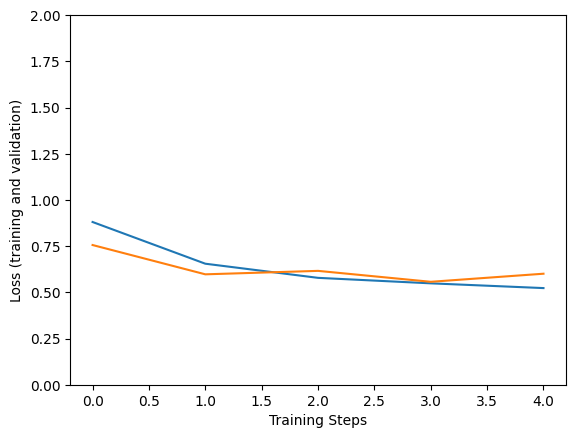

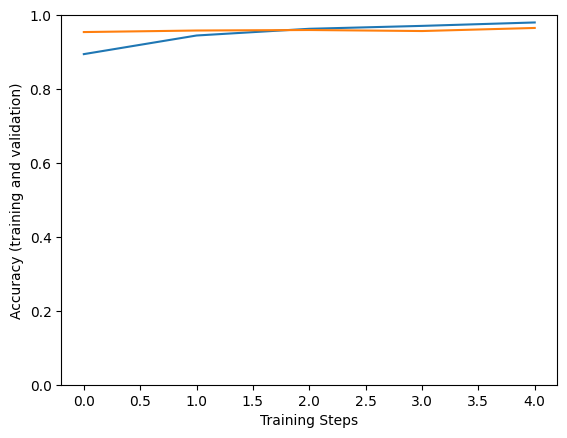

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

검증 데이터의 이미지에서 모델을 사용해 보세요.

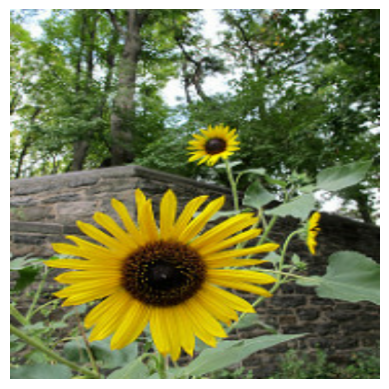

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 5s 5s/step


True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

마지막으로, 훈련한 모델을 다음과 같이 TF Serving 또는 TF Lite(모바일)에 배포하기 위해 저장할 수 있습니다.

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## 선택 사항: TensorFlow Lite에 배포

[TensorFlow Lite](https://www.tensorflow.org/lite)를 사용하면 TensorFlow 모델을 모바일 및 IoT 기기에 배포할 수 있습니다. 아래 코드는 훈련한 모델을 TF Lite로 변환하고 [TensorFlow 모델 최적화 도구 키트](https://www.tensorflow.org/model_optimization)의 훈련 후 도구를 적용하는 방법을 보여줍니다. 마지막으로, TF Lite Interpreter에서 모델을 실행하여 결과 품질을 검사합니다.

- 최적화 없이 변환하면 이전과 동일한 결과가 제공됩니다(최대 반올림 오차 포함).
- 데이터 없이 최적화를 이용해 변환하면 모델 가중치가 8bit로 양자화되지만 추론은 여전히 신경망 활성화에 부동 소수점 계산을 사용합니다. 그러면 모델 크기가 거의 4배 감소하고 모바일 기기의 CPU 대기 시간이 향상됩니다.
- 또한, 양자화 범위를 보정하기 위해 작은 참조 데이터세트가 제공되는 경우 신경망 활성화 계산도 8bit 정수로 양자화할 수 있습니다. 그 결과, 모바일 기기에서 추론 속도가 빨라지고 EdgeTPU와 같은 가속기에서 실행할 수 있습니다.

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2022-12-14 21:17:29.083085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-14 21:17:29.083128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


Wrote TFLite model of 826217852 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 48 of 50 examples (96%).
